# ADMISSIONS

## Functions

In [27]:
import numpy as np
import pandas as pd
import scipy.stats as st

def _stddev(mean_adm, sd_coeff, sd_const):
    return sd_coeff * mean_adm + sd_const

def get_admissions(alpha, loc, scale, peak_adm, sd_coeff, sd_const, n_days=92):
    """
    Generates wave of daily covid admissions.
    
    A gamma distribution function is scaled to use number of days on the x-axis
    and number of daily admissions of the y-axis.
    
    Noise is added to the signal according to a linear relationship between number
    of admissions and the corresponding standard deviation.
    
    Parameters
    ----------
    alpha : float
        gamma alpha
    loc : float
        gamma location
    scale : float
        gamma scale
    peak_adm : int
        gamma peak no. daily covid+ admissions
    sd_coeff : float
        coefficient of linear regression of mean admissions vs std dev.
    df_const : float
        constant of linear regression of mean admissions vs std dev.
    n_days : int, default 92
        number of days for calculation (no elements)
    
    Returns
    -------
    t : list of int
        day number
    y : list of float
        gamma value
    y_g : list of float
        gamma value with random variance according to standard deviation
    y_l : list of float
        lower bound for daily gamma value
    y_u : list of float
        upper bound for daily gamma value
        
    TODO
    ----
    Refactor to return dataframe
    """
    t = np.arange(0, n_days, 1)
    
    y = st.gamma.pdf(t, alpha, loc=loc, scale=scale)
    y = y*peak_adm/np.max(y)
    
    sd = _stddev(mean_adm=y, sd_coeff=sd_coeff, sd_const=sd_const)
    
    y_noise = st.norm.rvs(size=len(y)) * sd
    
    y_g = np.round(np.clip(y + y_noise, a_min=0, a_max=None)).astype(np.int)
    
    y_l = np.clip(y - 1.96*sd, a_min=0, a_max=None)
    y_u = np.clip(y + 1.96*sd, a_min=0, a_max=None)
    
    return pd.DataFrame(data={'y':y, 'y_gen':y_g, 'y_lower':y_l, 'y_upper':y_u}, index=pd.Series(t, name='Day'))

In [28]:
import numpy as np
import pandas as pd

def get_bed_occupancy(df, LoS_GIM, LoS_ICU, frac_ICU):
    """
    Generates GIM & ICU bed occupancy from daily covid admissions.
    
    Parameters
    ----------
    df : DataFrame
        admissions dataframe output of get_admissions()
    LoS_GIM : int
        ave. length of stay for Covid+ GIM patient
    LoS_ICU : int
        ave. length of stay for Covid+ ICU patient
    frac_ICU : float
        fraction of all admissions that are ICU patients
    
    Returns
    -------
    Day : list of int
        day number
    y : list of float
        gamma value
    y_g : list of float
        gamma value with random variance according to standard deviation
    y_l : list of float
        lower bound for daily gamma value
    y_u : list of float
        upper bound for daily gamma value
    GIM : list of int
        number of beds required for fitted curve of Covid+ GIM patients
    ICU : list of int
        number of beds required for fitted curve Covid+ ICU patients
    GIM_gen : list of int
        number of beds required for generated series Covid+ GIM patients
    ICU_gen : list of int
        number of beds required for generated series Covid+ ICU patients
    """
    df['GIM'] = ((1-frac_ICU)*df.y).rolling(LoS_GIM, min_periods=0).sum()
    df['ICU'] = ((frac_ICU)*df.y).rolling(LoS_ICU, min_periods=0).sum()
    
    df['GIM_gen'] = np.round((1-frac_ICU)*df.y_gen).rolling(LoS_GIM, min_periods=0).sum()
    df['ICU_gen'] = np.round((frac_ICU)*df.y_gen).rolling(LoS_ICU, min_periods=0).sum()
    
    return df

## Data import

In [29]:
import pandas as pd

path = '../Data/RAWDATA_Covid_Admissions.xlsx'
df_act = pd.read_excel(path, converters={
    'Date': pd.to_datetime,
    'Admissions': np.float64
})

## Plotting

In [34]:
from ipywidgets import widgets
import plotly.graph_objects as go

# Widgets
reset = widgets.Button(
    description='Reset',
    button_style='warning',
    tooltip='Reset sliders to default values',
    icon='refresh'
)

regen = widgets.Button(
    description='Randomize',
    button_style='',
    tooltip='Regenerate random series keeping all slider values',
    icon='refresh'
)

alpha = widgets.FloatSlider(
    value=6.57,
    min=0.1,
    max=10,
    step=0.05,
    description='alpha:',
    continuous_update=True,
    readout=True,
    readout_format='.2f',
)

loc = widgets.FloatSlider(
    value=0,
    min=-10,
    max=10,
    step=0.1,
    description='loc:',
    continuous_update=True,
    readout=True,
    readout_format='.1f',
)

scale = widgets.FloatSlider(
    value=6.56,
    min=0.1,
    max=10,
    step=0.01,
    description='scale:',
    continuous_update=True,
    readout=True,
    readout_format='.2f',
)

peak_adm = widgets.IntSlider(
    value=12,
    min=1,
    max=50,
    step=1,
    description='Peak adm.:',
    continuous_update=True,
)

sd_coeff = widgets.FloatSlider(
    value=0.3,
    min=0,
    max=1,
    step=0.01,
    description='σ coeff.:',
    continuous_update=True,
    readout=True,
    readout_format='.2f',
)

sd_const = widgets.FloatSlider(
    value=0.6,
    min=0,
    max=1,
    step=0.05,
    description='σ const.:',
    continuous_update=True,
    readout=True,
    readout_format='.2f',
)

sd_options = widgets.ToggleButtons(
    options=['Constant', 'Linear Correlation'],
    description='Variability:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Constant variability', 'Variability linearly related to daily admissions'],
    value='Linear Correlation'
)

LoS_GIM = widgets.IntSlider(
    value=9,
    min=1,
    max=50,
    step=1,
    description='LoS GIM:',
    continuous_update=True,
)

LoS_ICU = widgets.IntSlider(
    value=23,
    min=1,
    max=50,
    step=1,
    description='LoS ICU:',
    continuous_update=True,
)

frac_ICU = widgets.FloatSlider(
    value=0.25,
    min=0,
    max=1,
    step=0.01,
    description='% ICU:',
    continuous_update=True,
    readout=True,
    readout_format='.0%',
)


# Layout
layout = go.Layout(
    title='Covid admissions: Daily',
    xaxis={
        'title': 'Day'
    },
    yaxis={
        'title': 'No. admissions'
    },
    legend=dict(
        x=0,
        y=-0.5
    )
)

layout2 = go.Layout(
    title='Covid admissions: Cumulative',
    xaxis={
        'title': 'Day'
    },
    yaxis={
        'title': 'Cumulative no. admissions'
    },
    legend=dict(
        x=0,
        y=-0.5
    )
)

layout3 = go.Layout(
    title='Covid bed occupancy',
    xaxis={
        'title': 'Day'
    },
    yaxis={
        'title': 'No. beds'
    },
    legend=dict(
        x=1,
        y=1
    )
)


# Initialise
def get_admissions_params():
    """
    Returns dictionary of values of parameters for get_admissions()
    
    e.g. usage: 
        get_admissions(**get_admissions_params())
    """
    params = dict(alpha=alpha.value,
                  loc=loc.value,
                  scale=scale.value,
                  peak_adm=peak_adm.value,
                  sd_coeff=sd_coeff.value,
                  sd_const=sd_const.value)
    return params

def get_occupancy_params():
    """
    Returns dictionary of values of parameters for get_bed_occupancy()
    
    e.g. usage: 
        get_bed_occupancy(df, **get_occupancy_params())
    """
    params = dict(LoS_GIM=LoS_GIM.value,
                  LoS_ICU=LoS_ICU.value,
                  frac_ICU=frac_ICU.value)
    return params

df_gen = get_admissions(**get_admissions_params())
df_gen = get_bed_occupancy(df_gen, **get_occupancy_params())

# Set up plot traces
# - Daily data
data = []
data.append(go.Scatter(
    name = 'Probability density function',
    x = df_gen.index,
    y = df_gen.y_lower,
    mode='lines',
    line=dict(width=0),
    showlegend=False
))
data.append(go.Scatter(
    name = 'Probability density function',
    x = df_gen.index,
    y = df_gen.y,
    mode='lines',
    line=dict(color='rgb(0, 176, 246)'),
    fill='tonexty',
    fillcolor='rgba(0, 176, 246, 0.3)',
))
data.append(go.Scatter(
    name = 'Probability density function',
    x = df_gen.index,
    y = df_gen.y_upper,
    mode='lines',
    line=dict(width=0),
    fill='tonexty',
    fillcolor='rgba(0, 176, 246, 0.3)',
    showlegend=False
))
data.append(go.Scatter(
    name = 'Generated series',
    x = df_gen.index,
    y = df_gen.y_gen,
    mode='lines',
    line=dict(color='rgb(166, 139, 165)')
))
data.append(go.Scatter(
    name = 'Admissions (first wave)',
    x = df_gen.index,
    y = df_act.Admissions,
    mode='lines',
    line=dict(color='rgb(98, 76, 171)'),
))

# - Cumulative data
data2 = []
data2.append(go.Scatter(
    name = 'Probability density function',
    x = df_gen.index,
    y = df_gen.y.cumsum(),
    mode='lines',
    line=dict(color='rgb(0, 176, 246)'),
))
data2.append(go.Scatter(
    name = 'Generated series',
    x = df_gen.index,
    y = df_gen.y_gen.cumsum(),
    mode='lines',
    line=dict(color='rgb(166, 139, 165)')
))
data2.append(go.Scatter(
    name = 'Admissions (first wave)',
    x = df_gen.index,
    y = df_act.Admissions.cumsum().values,
    mode='lines',
    line=dict(color='rgb(98, 76, 171)'),
))

data3 = []
data3.append(go.Scatter(
    name = 'Generated GIM',
    x = df_gen.index,
    y = df_gen.GIM_gen,
    mode='lines',
    line=dict(color='rgb(166, 139, 165)')
))
data3.append(go.Scatter(
    name = 'Actual GIM',
    x = df_gen.index,
    y = df_act['GIM bed occupancy'],
    mode='lines',
    line=dict(color='rgb(98, 76, 171)')
))
data3.append(go.Scatter(
    name = 'Fitted GIM',
    x = df_gen.index,
    y = df_gen.GIM,
    mode='lines',
    line=dict(color='rgb(0, 176, 246)'),
))
data3.append(go.Scatter(
    name = 'Generated ICU',
    x = df_gen.index,
    y = df_gen.ICU_gen,
    mode='lines',
    line=dict(color='rgb(166, 139, 165)', dash='dot')
))
data3.append(go.Scatter(
    name = 'Actual ICU',
    x = df_gen.index,
    y = df_act['ICU bed occupancy'],
    mode='lines',
    line=dict(color='rgb(98, 76, 171)', dash='dot'),
))
data3.append(go.Scatter(
    name = 'Fitted ICU',
    x = df_gen.index,
    y = df_gen.ICU,
    mode='lines',
    line=dict(color='rgb(0, 176, 246)', dash='dot'),
))


# Plot
g = go.FigureWidget(data=data, layout=layout)
g2 = go.FigureWidget(data=data2, layout=layout2)
g3 = go.FigureWidget(data=data3, layout=layout3)


# Responsive functions
def response(change):
    df_gen = get_admissions(**get_admissions_params())
    df_gen = get_bed_occupancy(df_gen, **get_occupancy_params())

    with g.batch_update():
        g.data[0].y = df_gen.y_lower
        g.data[1].y = df_gen.y
        g.data[2].y = df_gen.y_upper
        g.data[3].y = df_gen.y_gen
        
    with g2.batch_update():
        g2.data[0].y = df_gen.y.cumsum()
        g2.data[1].y = df_gen.y_gen.cumsum()
        
    with g3.batch_update():
        g3.data[0].y = df_gen.GIM_gen
        g3.data[2].y = df_gen.GIM
        g3.data[3].y = df_gen.ICU_gen
        g3.data[5].y = df_gen.ICU
    
    return
        
def reset_values(change):
    alpha.value = 6.57
    loc.value = 0
    scale.value = 6.56 
    peak_adm.value = 12
    sd_coeff.value = 0.3
    sd_const.value = 0.6
    LoS_GIM.value = 9      # 9
    LoS_ICU.value = 23     # 18
    frac_ICU.value = 0.25  # 0.19
    
    response(None)
    return

def variability(change):
    if change['new'] == 'Constant':
        sd_coeff.value = 0
        sd_const.value = 0.75
        sd_coeff.disabled = True
    elif change['new'] == 'Linear Correlation':
        sd_coeff.value = 0.3
        sd_const.value = 0.6
        sd_coeff.disabled = False
    return


# Link widgets to functions
reset.on_click(reset_values)
regen.on_click(response)
sd_options.observe(variability, names='value')
alpha.observe(response, names='value')
loc.observe(response, names='value')
scale.observe(response, names='value')
peak_adm.observe(response, names='value')
sd_coeff.observe(response, names='value')
sd_const.observe(response, names='value')
LoS_GIM.observe(response, names='value')
LoS_ICU.observe(response, names='value')
frac_ICU.observe(response, names='value')


# Display widgets & plots
gamma_control = widgets.VBox([
    widgets.HTML(value='<h4>Gamma parameters</h4>'),
    alpha,
    loc,
    scale,
    peak_adm,
])
magnitude_control = widgets.VBox([
    widgets.HTML(value='<h4>Variability parameters</h4>'),
    sd_coeff,
    sd_const,
    sd_options
])
control = widgets.HBox([
    gamma_control,
    magnitude_control
])
occ_control = widgets.VBox([
    LoS_GIM,
    LoS_ICU,
    frac_ICU
])


widgets.VBox([
    control,
    widgets.HBox([reset, regen]),
    widgets.HBox([g,g2]),
    widgets.HBox([g3, occ_control])
])

# OCCUPANCY

## Data import

In [4]:
import pandas as pd

path = '../Data/RAWDATA_Covid_Admissions.xlsx'
    'Date': pd.to_datetime,
    'Admissions': pd.to_numeric
})

In [5]:
df.head()

,Date,Admissions,GIM bed occupancy,ICU bed occupancy,Total bed occupancy
0,2020-03-01,0,0,0,0
1,2020-03-02,0,0,0,0
2,2020-03-03,0,0,0,0
3,2020-03-04,0,0,0,0
4,2020-03-05,0,0,0,0


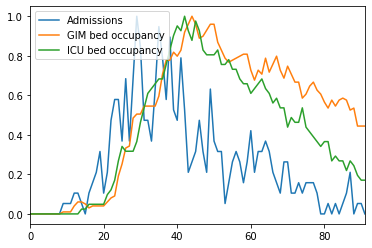

In [17]:
import matplotlib.pyplot as plt

_norm = lambda x : x/x.max()

_norm(df['Admissions']).plot()
_norm(df['GIM bed occupancy']).plot()
_norm(df['ICU bed occupancy']).plot()
plt.legend()
plt.show()